## Summary
This project involves implementing the Sessa Empirical Estimator (SEE) for estimating prescription durations in a pharmacoepidemiological context. Originally written in R, the SEE will be ported to Python, and applied to a chosen dataset. The standard SEE approach uses K-Means clustering to group similar prescription intervals, but this project will also explore an alternative clustering algorithm to see if it produces different insights. Finally, the results and performance from both clustering methods will be compared, highlighting any differences in exposure classification or prescription duration estimates.

## Objective

#### 1. Replicate the SEE Methodology:
- Convert the SEE R code into Python and validate its functionality on a dataset.
- Implement K-Means clustering to estimate prescription durations and identify exposure windows.

#### 2. Explore an Alternative Clustering Algorithm:
- Substitute K-Means with a different clustering approach (e.g., DBSCAN, Hierarchical Clustering, or GMM).
- Compare the resulting clusters, prescription durations, and exposure periods to those from K-Means.

#### 3. Evaluate and Compare Results:
- Generate metrics and visualizations to illustrate how each clustering algorithm performs.
- Discuss strengths, weaknesses, and potential applications of each approach.

#### 4. Document Findings and Insights:
- Summarize the differences in performance and outcomes between K-Means-based SEE and the alternative method.
- Provide clear recommendations on how clustering choice can affect pharmacoepidemiological analyses.

___

# Process


In [29]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


### Data Acquisition & Preparation

1. First, we simulate a dataset based on the link provided, ensuring that the dataset has "prescription-like" intervals.

In [30]:
random.seed(42)
n_patients = 1000
obs_period = 720
start_date = datetime(2020,1,1)
ATC_code = "ABC123"

np.random.seed(42)
groups = np.random.choice(
    [1,2,3,4,5,6],
    size=n_patients,
    p=[0.1,0.2,0.2,0.2,0.2,0.1]
)

def simulate_patient(pid, group, start, obs_days):
    rows=[]
    current_date = start
    duration=30 # initial
    rows.append({"pnr":pid,"eksd":current_date,"perday":1,"ATC":ATC_code,"dur_original":duration})
    refill_idx=1
    end_date = start+timedelta(days=obs_days)

    while True:
        if group==1:
            delay=0
        elif group==2:
            delay = random.randint(0,30)
        elif group==3:
            delay = refill_idx*5
        elif group==4:
            delay=0 if (refill_idx%2==0) else 15
        elif group==5:
            delay=0 if (refill_idx<=3) else 60
        elif group==6:
            if refill_idx>1: break
            delay=0
        else:
            delay=0
        duration=int(np.random.choice([30,60,90]))
        next_fill = current_date+timedelta(days=duration+delay)
        if next_fill> end_date:
            break
        rows.append({"pnr":pid,"eksd":next_fill,"perday":1,"ATC":ATC_code,"dur_original":duration})
        current_date=next_fill
        refill_idx+=1
    return rows

all_rows=[]
for i in range(n_patients):
    pat_id=i+1
    grp=groups[i]
    sim = simulate_patient(pat_id,grp,start_date,obs_period)
    all_rows.extend(sim)

sim_df = pd.DataFrame(all_rows)
sim_df["eksd"] = pd.to_datetime(sim_df["eksd"])
print("Simulated shape:", sim_df.shape)
print(sim_df.head(10))

Simulated shape: (9316, 5)
   pnr       eksd  perday     ATC  dur_original
0    1 2020-01-01       1  ABC123            30
1    1 2020-04-05       1  ABC123            90
2    1 2020-06-14       1  ABC123            60
3    1 2020-09-27       1  ABC123            90
4    1 2021-01-15       1  ABC123            90
5    1 2021-03-11       1  ABC123            30
6    1 2021-05-10       1  ABC123            30
7    1 2021-09-12       1  ABC123            90
8    1 2021-11-21       1  ABC123            30
9    2 2020-01-01       1  ABC123            30


## Helper Plots


In [31]:
def plot_ecdf(data, title="ECDF", color="blue"):
    # data must be 1D array
    data_sorted = np.sort(data)
    yvals = np.arange(1,len(data_sorted)+1)/float(len(data_sorted))
    plt.figure(figsize=(6,4))
    plt.plot(data_sorted, yvals, color=color)
    plt.title(title)
    plt.xlabel("event_interval")
    plt.ylabel("ECDF")
    plt.show()


def plot_freq_of_patients(df, title="Frequency Plot of Random Prescriptions"):
    # df is expected to have one row per pnr if we already sampled randomly.
    # We do a count of rows per pnr.
    counts = df["pnr"].value_counts()
    plt.figure(figsize=(6,4))
    sns.histplot(counts, kde=False)
    plt.title(title)
    plt.xlabel("Number of Random Prescriptions per pnr")
    plt.ylabel("Frequency")
    plt.show()


def plot_density_log(data, title="Density of Log-Intervals"):
    # data is 1D (log of intervals)
    plt.figure(figsize=(6,4))
    sns.kdeplot(data, fill=True)
    plt.title(title)
    plt.xlabel("log(event_interval)")
    plt.show()


def plot_silhouette(X, labels):
    sil_vals = silhouette_samples(X, labels)
    avg_sil = np.mean(sil_vals)
    clusts = np.unique(labels)
    y_lower=10
    plt.figure(figsize=(7,5))
    for c in clusts:
        c_sil = np.sort(sil_vals[labels==c])
        y_upper = y_lower+len(c_sil)
        color = sns.color_palette("hls", len(clusts))[c]
        plt.barh(range(y_lower,y_upper), c_sil,height=1.0,color=color)
        plt.text(-0.05, (y_lower+y_upper)/2, str(c))
        y_lower=y_upper+10
    plt.axvline(avg_sil, color="red", linestyle="--")
    plt.title("Silhouette Plot")
    plt.xlabel("Coefficient")
    plt.ylabel("Cluster")
    plt.show()

## Silhouette Plotting Function

In [32]:

def plot_silhouette(X, labels):
    sil_vals = silhouette_samples(X, labels)
    avg_sil = np.mean(sil_vals)
    clusters = np.unique(labels)
    y_lower = 10

    plt.figure(figsize=(7,5))
    for c in clusters:
        c_sil = np.sort(sil_vals[labels == c])
        y_upper = y_lower + len(c_sil)
        color = sns.color_palette("hls", len(clusters))[c]
        plt.barh(range(y_lower, y_upper), c_sil, height=1.0, color=color)
        plt.text(-0.05, (y_lower+y_upper)/2, str(c))
        y_lower = y_upper + 10
    plt.axvline(avg_sil, color="red", linestyle="--")
    plt.title("Silhouette Plot")
    plt.xlabel("Coefficient")
    plt.ylabel("Cluster")
    plt.show()


## R -> Python Code (SEE Implementation)

In [33]:
def see_estimator(df, atc):
    dff = df[df["ATC"]==atc].copy()
    if dff.empty:
        df["Median"]=np.nan
        return df
    dff.sort_values(["pnr","eksd"], inplace=True)
    dff["prev_eksd"] = dff.groupby("pnr")["eksd"].shift(1)
    dff.dropna(subset=["prev_eksd"], inplace=True)
    if dff.empty:
        df["Median"]=np.nan
        return df

    dff["event_interval"] = (dff["eksd"]-dff["prev_eksd"]).dt.days

    # (1) Full ECDF
    plot_ecdf(dff["event_interval"], title="100% ECDF of event_interval", color="purple")

    # random pick 1 row per pnr
    def pick_rand(g):
        return g.sample(n=1, random_state=None)

    df_random = dff.groupby("pnr", group_keys=False).apply(pick_rand)

    # frequency plot of random prescriptions
    plot_freq_of_patients(df_random, title="Frequency Plot of Random Prescriptions per pnr")

    # (2) 80% ECDF
    p80 = np.percentile(df_random["event_interval"],80)
    df_ecdf_80 = df_random[df_random["event_interval"]<=p80].copy()
    if df_ecdf_80.empty:
        df["Median"]=np.nan
        return df
    plot_ecdf(df_random["event_interval"], title="100% ECDF (Random)", color="green")
    # also plot partial (80%) if you want a separate one
    partial_80 = df_random[df_random["event_interval"]<=p80]["event_interval"]
    plot_ecdf(partial_80, title="80% ECDF (Random)", color="red")

    # (3) density of log intervals, after filtering.
    # we take df_ecdf_80 event_interval, log them.
    logvals = np.log(df_ecdf_80["event_interval"].clip(lower=1e-9))
    plot_density_log(logvals, title="Density of log(event_interval) 80% subset")

    # silhouette-based k
    X = df_ecdf_80[["event_interval"]].values
    best_k=2
    best_sil=-1
    for k in range(2,8):
        km=KMeans(n_clusters=k, random_state=42)
        labs=km.fit_predict(X)
        sil=silhouette_score(X, labs)
        if sil>best_sil:
            best_sil=sil
            best_k=k
    print(f"Best k={best_k}, silhouette={best_sil:.3f}")
    final_km=KMeans(n_clusters=best_k, random_state=42)
    final_labs=final_km.fit_predict(X)

    # silhouette plot
    plot_silhouette(X, final_labs)

    df_ecdf_80["cluster"] = final_labs
    df_ecdf_80["log_interval"] = np.log(df_ecdf_80["event_interval"].clip(lower=1e-9))
    meds = df_ecdf_80.groupby("cluster")["log_interval"].median().reset_index()
    meds.columns=["cluster","median_log"]
    meds["median_duration"] = np.exp(meds["median_log"])

    df_ecdf_80 = df_ecdf_80.merge(meds, on="cluster", how="left")
    df_ecdf_80["Median"] = df_ecdf_80["median_duration"]

    freq = df_ecdf_80["cluster"].value_counts()
    main_cluster = freq.idxmax()
    main_m = meds.loc[meds["cluster"]==main_cluster, "median_duration"].values[0]

    df_random_merged = df_random.merge(
        df_ecdf_80[["pnr","eksd","Median"]],
        on=["pnr","eksd"], how="left"
    )
    df_random_merged["Median"] = df_random_merged["Median"].fillna(main_m)

    df_final = df.merge(
        df_random_merged[["pnr","Median"]],
        on="pnr", how="left"
    )
    df_final["Median"] = df_final["Median"].fillna(main_m)

    return df_final

def see_assumption_boxplot(df, atc):
    # compute durations for each consecutive fill
    dff = df[df["ATC"]==atc].copy()
    dff.sort_values(["pnr","eksd"], inplace=True)
    dff["prev_eksd"] = dff.groupby("pnr")["eksd"].shift(1)
    dff.dropna(subset=["prev_eksd"], inplace=True)
    if dff.empty:
        print("No data for boxplot.")
        return

    dff["Duration"] = (dff["eksd"] - dff["prev_eksd"]).dt.days
    dff["p_number"] = dff.groupby("pnr").cumcount()+1

    # boxplot p_number vs Duration
    plt.figure(figsize=(7,5))
    sns.boxplot(x="p_number", y="Duration", data=dff)
    plt.title("Boxplot of Prescription Duration by Refill Index")

    # Overplot a horizontal line at the median of medians
    med_of_meds = dff.groupby("pnr")["Duration"].median().median()
    plt.axhline(y=med_of_meds, color="red", linestyle="--")
    plt.show()

    print(f"Median of medians across patients = {med_of_meds}")

## Main Code

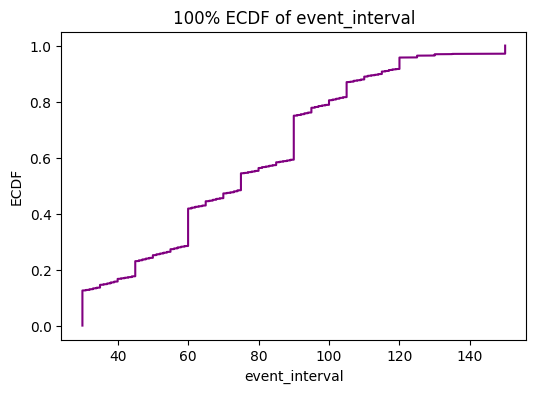

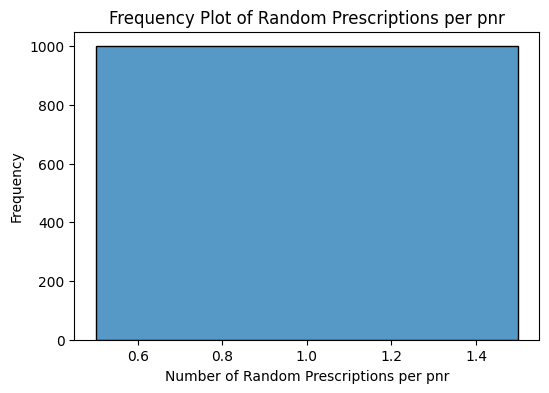

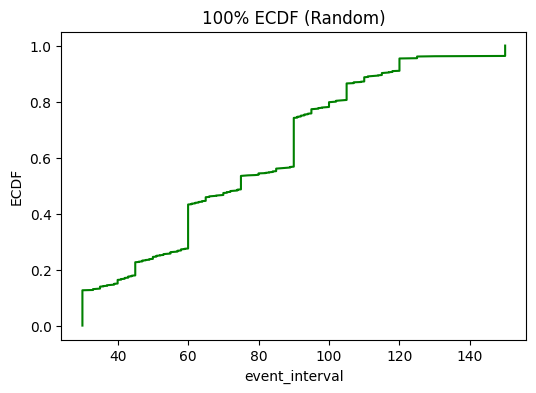

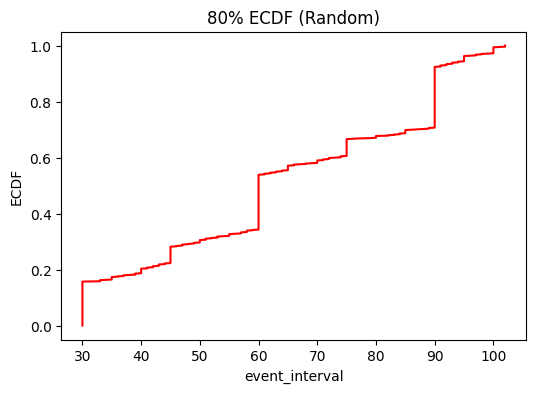

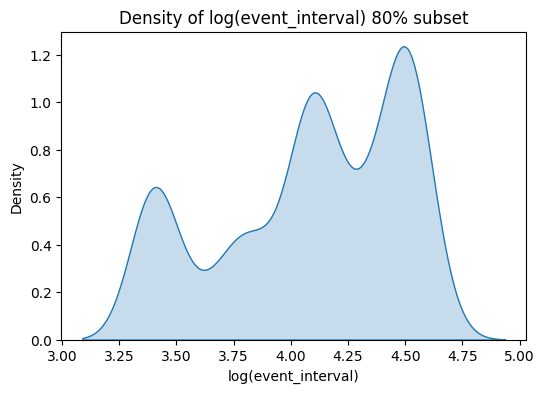

Best k=6, silhouette=0.810


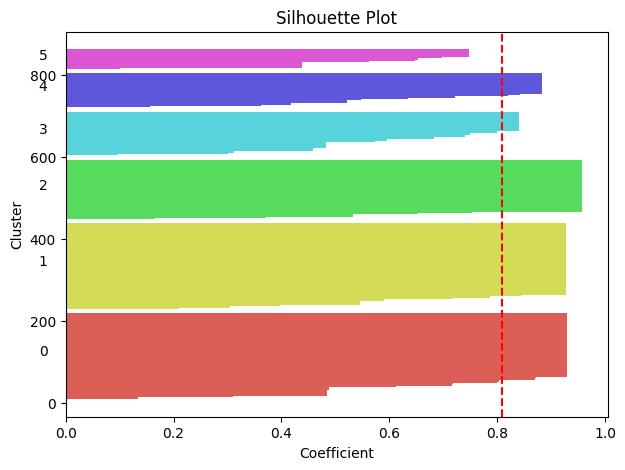

Final shape: (9316, 6)
   pnr       eksd  perday     ATC  dur_original  Median
0    1 2020-01-01       1  ABC123            30    60.0
1    1 2020-04-05       1  ABC123            90    60.0
2    1 2020-06-14       1  ABC123            60    60.0
3    1 2020-09-27       1  ABC123            90    60.0
4    1 2021-01-15       1  ABC123            90    60.0
5    1 2021-03-11       1  ABC123            30    60.0
6    1 2021-05-10       1  ABC123            30    60.0
7    1 2021-09-12       1  ABC123            90    60.0
8    1 2021-11-21       1  ABC123            30    60.0
9    2 2020-01-01       1  ABC123            30    60.0

Boxplot from see_assumption-like function:


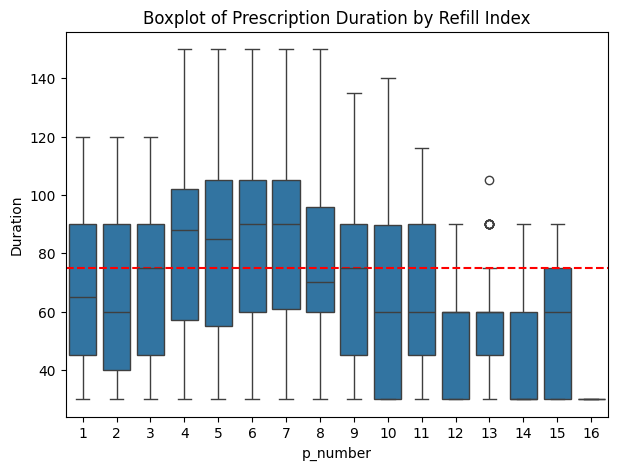

Median of medians across patients = 75.0


In [34]:
if __name__=="__main__":
    final_df = see_estimator(sim_df, "ABC123")
    print("Final shape:", final_df.shape)
    print(final_df.head(10))

    print("\nBoxplot from see_assumption-like function:")
    see_assumption_boxplot(sim_df, "ABC123")
